# Example Neural Network

Example notebook for building and training a Keras neural network for regression

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Statements

Module requirements
- tensorflow >= 2.4.1
- keras >= 2.2.5
- numpy >= 1.19.5  
- pandas >= 1.3.1
- sklearn >= 0.24.2
- matplotlib >= 3.4.2

To upgrade a python module called `NAME`, run the following to get the latest version:  
`pip install NAME -U`

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import tensorflow.keras as keras # Load keras via tensorflow

from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger

In [5]:
# Set random seed (typically prime number) for reproducability
random_seed = 1777
np.random.seed(random_seed)

## Load Data

https://keras.io/api/datasets/boston_housing/

Loads the Boston Housing dataset.

This is a dataset taken from the StatLib library which is maintained at Carnegie Mellon University.

Samples contain 13 attributes of houses at different locations around the Boston suburbs in the late 1970s. Targets are the median values (MEDV) of the houses at a location (in k$).

The attributes themselves are defined in the StatLib website (http://lib.stat.cmu.edu/datasets/boston)

For this example, I remove the `CHAS` column for simplicity

In [6]:
# Load example dataset 
# The function already does train/test split, but combinining them into one for the sake of the notebook
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz")

# Input Data
x_data = np.concatenate([x_train, x_test]) 

# Output data
y_data = np.concatenate([y_train, y_test])
y_data = np.expand_dims(y_data, axis=-1)

# Combined (with target value at the end)
housing_data = np.concatenate([x_data, y_data], axis=-1)

57344/57026 [==============================] - 0s 1us/step


In [7]:
housing_data.shape

(506, 14)

In [8]:
# For visualization
house_df = pd.DataFrame(housing_data)

col_names = ['CRIM','ZN', 'INDUS', "CHAS", 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
name_dict = {}
for i in range(len(col_names)):
    name_dict[i] = col_names[i]


house_df = house_df.rename(columns=name_dict)

# For this example, we are dropping the CHAS variable for simplicity
house_df = house_df.drop(columns='CHAS')

# Retrive data without CHAS column
housing_data = house_df.to_numpy()
y_column = -1
x_data = housing_data[:, :y_column]
y_data = housing_data[:, y_column:]

house_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,1.23247,0.0,8.14,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72,15.2
1,0.02177,82.5,2.03,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11,42.3
2,4.89822,0.0,18.10,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26,50.0
3,0.03961,0.0,5.19,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01,21.1
4,3.69311,0.0,18.10,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65,17.7


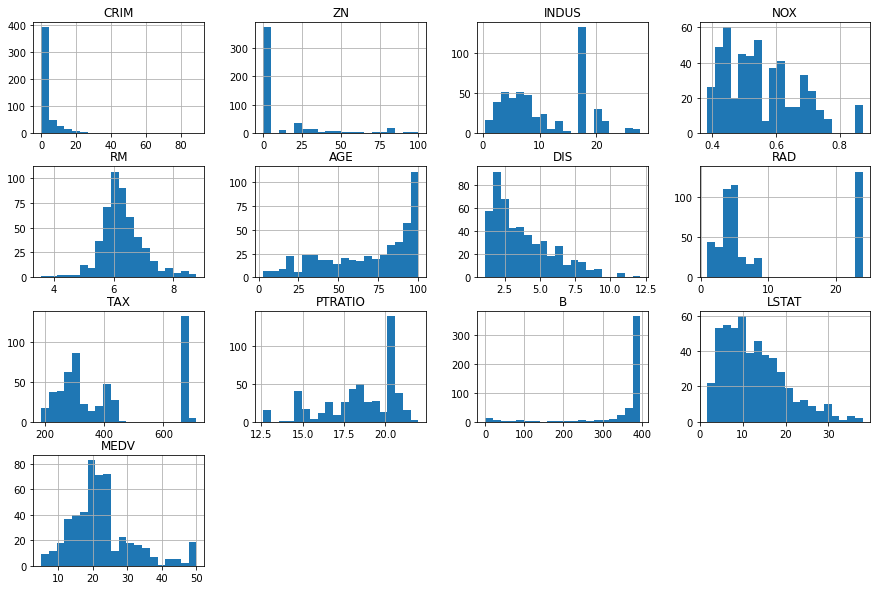

In [9]:
# Plot Distributiosn
house_df.hist(figsize=(15, 10), bins=20)
plt.show()

## Split Data into Training/Validation/Test sets

In [10]:
# Ratio of Splits
train_split = 0.7
val_split = 0.15
test_split = 1 - train_split - val_split

nsamples = x_data.shape[0]
nval = int(nsamples * val_split)


# Split data
x_train, x_tmp, y_train, y_tmp = train_test_split(x_data, y_data, train_size=train_split)
x_val, x_test, y_val, y_test = train_test_split(x_tmp, y_tmp, train_size=nval)

In [11]:
x_train.shape

(354, 12)

In [12]:
y_train.shape

(354, 1)

## Preprocess Data
The preprocessing is first performed on the training set, then apply to the val/test set

Since each of the input attributes and the output attribute are on different scales, we normalize each one independently. 

We will use the sklearn StandardScaler to perform normalizatin of mean-center and unit variance, since it centering and scaling happen independently on each feature 

In [13]:
# Normalize input data
x_scaler = StandardScaler()
norm_x_train = x_scaler.fit_transform(x_train)

# Apply fitted scaler to validation and test set
norm_x_val = x_scaler.transform(x_val)
norm_x_test = x_scaler.transform(x_test)

# Now normalize output data
y_scaler = StandardScaler()
norm_y_train = y_scaler.fit_transform(y_train)

norm_y_val = y_scaler.transform(y_val)
norm_y_test = y_scaler.transform(y_test)

In [24]:
y_train.shape

(354, 1)

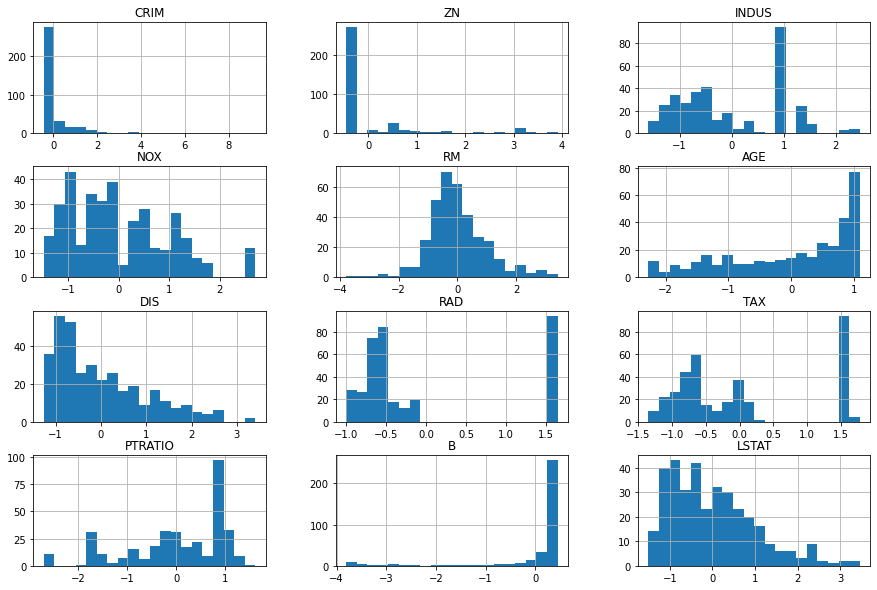

In [14]:
# Visualization of normalized training data
new_col_names = ['CRIM','ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
norm_train_df = pd.DataFrame(norm_x_train, columns=new_col_names)

norm_train_df.hist(figsize=(15, 10), bins=20)
plt.show()

## Build Model

In [15]:
# Clear any existin models
keras.backend.clear_session()

# Input layer for your model, where shape is the number of input features
# norm_x_train.shape = (Number of training samples, number of input featurs)

ninput_features = norm_x_train.shape[1:]
nout = norm_y_train.shape[1]

input_layer = Input(shape=ninput_features)

# Dense layer with Relu
nunits = 16
x = Dense(nunits)(input_layer)
x = Activation('relu')(x)

# Dense layer with Relu
nunits = 8
x = Dense(nunits)(x)
x = Activation('relu')(x)
# Output layer
out = Dense(nout)(x)

model = Model(input_layer, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                208       
_________________________________________________________________
activation (Activation)      (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
activation_1 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 353
Trainable params: 353
Non-trainable params: 0
_______________________________________________________________

## Select Loss Function, Learning Rate, and Optimizer 

Regression problems typucally  use mean_squared_erro

In [16]:
learning_rate = 0.001
loss_function = 'mean_squared_error'

# Using the ADam optimizer for this example
optimizer = Adam(lr=learning_rate)

# Compile model with optimizer and learning rate
model.compile(optimizer=optimizer, loss=loss_function)

C:\Users\pierc\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## Train Model

In [17]:
#Number of epochs to train
epochs = 30

# Number of samples it trains on at a time
batch_size = 16

# Name of model
model_name = 'example_model'

# Directory to save model
model_save_dir = "example_dir"
os.makedirs(model_save_dir, exist_ok=True)

# CSV file that keeps track of training and validation loss
csv_file = "{}_training.csv".format(model_name)
train_csv = os.path.join(model_save_dir, csv_file)
csv_logger = CSVLogger(train_csv)
callbacks=[csv_logger]

history = model.fit(x=norm_x_train, y=norm_y_train,
        epochs=epochs, batch_size=batch_size,
        validation_data=(norm_x_val, norm_y_val),
        callbacks=callbacks)

Epoch 1/30
23/23 [==============================] - 0s 5ms/step - loss: 1.7385 - val_loss: 1.2223
Epoch 2/30
23/23 [==============================] - 0s 1ms/step - loss: 1.1146 - val_loss: 0.8184
Epoch 3/30
23/23 [==============================] - 0s 1ms/step - loss: 0.8584 - val_loss: 0.6128
Epoch 4/30
23/23 [==============================] - 0s 1ms/step - loss: 0.6965 - val_loss: 0.4747
Epoch 5/30
23/23 [==============================] - 0s 1ms/step - loss: 0.5735 - val_loss: 0.3761
Epoch 6/30
23/23 [==============================] - 0s 1ms/step - loss: 0.4849 - val_loss: 0.3115
Epoch 7/30
23/23 [==============================] - 0s 1ms/step - loss: 0.4137 - val_loss: 0.2648
Epoch 8/30
23/23 [==============================] - 0s 1ms/step - loss: 0.3604 - val_loss: 0.2340
Epoch 9/30
23/23 [==============================] - 0s 1ms/step - loss: 0.3224 - val_loss: 0.2090
Epoch 10/30
23/23 [==============================] - 0s 1ms/step - loss: 0.2915 - val_loss: 0.1958
Epoch 11/30
23/23 [

## Plot training loss

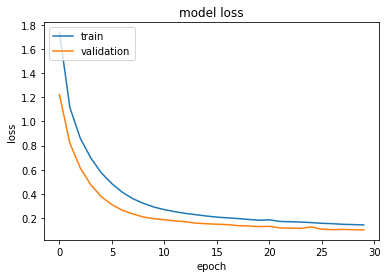

In [18]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Run Trained Model on Test Set

Test MSE: 10.15


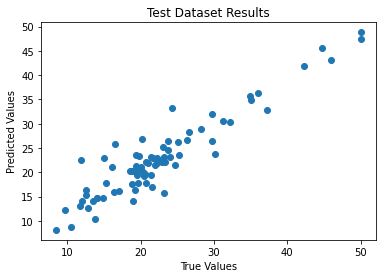

In [19]:
predict_test = model.predict(norm_x_test)

# Rescale prediction to original scale
predict_values = y_scaler.inverse_transform(predict_test)

# Caclulate mean-square-error on data
test_mse = sklearn.metrics.mean_squared_error(y_test, predict_values)
print(f"Test MSE: {test_mse:.4}")

# Compare to y_test values
plt.scatter(y_test, predict_values)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Test Dataset Results")
plt.show()

Train MSE: 12.27


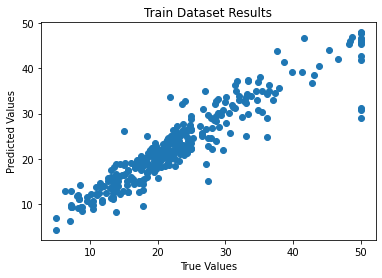

In [20]:
# RUn test on trained dataset
predict_train = model.predict(norm_x_train)

predict_values = y_scaler.inverse_transform(predict_train)

# Caclulate mean-square-error on data
train_mse = sklearn.metrics.mean_squared_error(y_train, predict_values)
print(f"Train MSE: {train_mse:.4}")

# Compare to y_train values
plt.scatter(y_train, predict_values)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Train Dataset Results")
plt.show()

## Save Model

In [21]:
model_save_name = f"{model_name}_model.h5"
save_path = os.path.join(model_save_dir, model_save_name)
model.save(save_path)